In [7]:
import numpy as np
import matplotlib.pyplot as plt
from dlordinal.datasets import FGNet
from dlordinal.losses import TriangularCrossEntropyLoss
from skorch import NeuralNetClassifier
import torch
from torch import nn
from torch.optim import Adam
from torchvision import models
from torchvision.transforms import Compose, ToTensor

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
optimiser_params = {"lr": 1e-3, "bs": 400, "epochs": 5, "s": 2, "c": 0.2, "beta": 0.5}
workers = 3

torch.serialization.add_safe_globals([
    models.ResNet, nn.Conv2d, nn.BatchNorm2d
])

In [8]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        raise Exception("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        raise Exception("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

In [9]:
from torch.utils.data import DataLoader

fgnet_train = FGNet(
    root="./datasets",
    train=True,
    target_transform=np.array,
    transform=Compose([ToTensor()]),
)
fgnet_test = FGNet(
    root="./datasets",
    train=False,
    target_transform=np.array,
    transform=Compose([ToTensor()]),
)

Files already downloaded and verified
Files already processed and verified
Files already split and verified
Files already downloaded and verified
Files already processed and verified
Files already split and verified


In [10]:
from sklearn.model_selection import train_test_split
import numpy as np

# Get targets as a numpy array
targets = np.array([y for _, y in fgnet_train])

# Split into fit + calibration sets
X_train_idx, X_calib_idx, y_train, y_calib = train_test_split(
    np.arange(len(fgnet_train)),
    targets,
    test_size=0.2,
    random_state=42,
    stratify=targets
)

# Create subsets for fitting and calibration
from torch.utils.data import Subset

fgnet_fit = Subset(fgnet_train, X_train_idx)
fgnet_calib = Subset(fgnet_train, X_calib_idx)

In [ ]:
num_classes_fgnet = len(fgnet_train.classes)

# Model
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, num_classes_fgnet)
model = model.to(device)

loss_fn = TriangularCrossEntropyLoss(num_classes=num_classes_fgnet).to(device)

# Skorch estimator
classifier = NeuralNetClassifier(
    module=model,
    criterion=loss_fn,
    optimizer=Adam,
    lr=optimiser_params["lr"],
    max_epochs=optimiser_params["epochs"],
    train_split=None,
    callbacks=[],
    device=device,
    # verbose=0,
    iterator_train__batch_size=optimiser_params["bs"],
    iterator_train__shuffle=True,
    iterator_train__num_workers=workers - 1,
    iterator_train__pin_memory=True,
    iterator_valid__batch_size=optimiser_params["bs"],
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=workers - 1,
    iterator_valid__pin_memory=True,
)
classifier.fit(X=fgnet_fit, y=y_train)

In [6]:
from deel.puncc.api.prediction import BasePredictor
from deel.puncc.classification import LAC
from torch.nn.functional import softmax

class SkorchPredictor(BasePredictor):
    def predict(self, X, **kwargs):
        logits = self.model.predict(X, **kwargs)
        logits_tensor = torch.from_numpy(logits).float()

        if logits_tensor.ndim == 1:
            logits_tensor = logits_tensor.unsqueeze(0)

        probs = softmax(logits_tensor, dim=1).numpy()
        return probs

predictor = SkorchPredictor(classifier)
lac_cp = LAC(
    SkorchPredictor(predictor), train=False
)


X_fit = [fgnet_fit[i][0].numpy() for i in range(len(fgnet_fit))]
y_fit = [fgnet_fit[i][1] for i in range(len(fgnet_fit))]
X_calib = [fgnet_calib[i][0].numpy() for i in range(len(fgnet_calib))]
y_calib = [fgnet_calib[i][1] for i in range(len(fgnet_calib))]

X_fit = np.stack(X_fit)
X_calib = np.stack(X_calib)
y_fit = np.array(y_fit)
y_calib = np.array(y_calib)

lac_cp.fit(X_fit=X_fit, y_fit=y_fit, X_calib=X_calib, y_calib=y_calib)


KeyboardInterrupt



Average prediction intervals width (sharpness): 2.000
Average coverage: 0.905


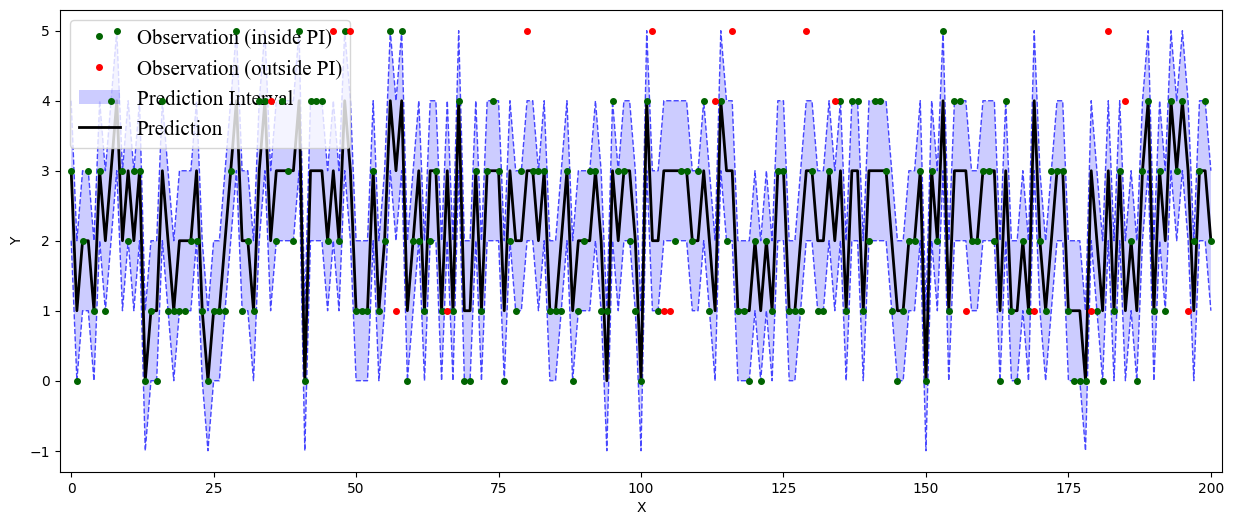

In [6]:
from deel.puncc.metrics import classification_mean_coverage, classification_mean_size
from deel.puncc.plotting import plot_prediction_intervals

# Maximum allowed error rate
alpha = 0.2

X_test = [fgnet_test[i][0].numpy() for i in range(len(fgnet_test))]
y_test = [fgnet_test[i][1] for i in range(len(fgnet_test))]

X_test = np.stack(X_test)
y_test = np.array(y_test)

# Compute prediction intervals and metrics on the test set
y_pred, set_pred = lac_cp.predict(X_test, alpha=alpha)

size = classification_mean_size(set_pred)
coverage = classification_mean_coverage(y_test, set_pred)
print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average prediction set size: {np.round(size, 2)}")

In [ ]:
from random import random

class_names = ['0-6','7-12','13-19','20-35','36-50','51-99']  # Adjust based on your dataset

# Number of samples to visualize
n_samples = 15
indices = random.sample(range(len(X_test)), n_samples)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    image = X_test[idx]  # Image corresponding to X_test[idx]
    true_label = y_test[idx]
    pred_set = set_pred[idx]

    is_correct = true_label in pred_set
    color = "green" if is_correct else "red"

    plt.subplot(3, 5, i + 1)
    plt.imshow(image.astype("uint8"))  # Adjust if your image format differs
    plt.axis('off')
    plt.title(
        f"True: {class_names[true_label]}\nPred: {', '.join([class_names[i] for i in pred_set])}",
        color=color,
        fontsize=9
    )

plt.tight_layout()
plt.show()